# Entrenamiento y Validación de los diferentes modelos de Clasificación

### Importación de las librerías necesarias

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SkPipe
from scipy.stats import randint, loguniform, uniform

### Lectura e integración de los datos

#### Lectura de los datos de análisis de toxinas.

In [168]:
df_toxinas = pd.read_excel("completo_TPM.xlsx")
df_toxinas.head()

,Fecha,Resultado_cat,ultimoAnalisis
0,2021-01-01,0,0
1,2021-01-02,0,0
2,2021-01-03,0,0
3,2021-01-04,0,0
4,2021-01-05,0,0


#### Lectura de los datos meteorológicos

In [169]:
df_meteorologicos = pd.read_csv("POWER_LARC_unido.csv")
df_meteorologicos.head()

,Fecha,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UVA,...,PRECTOTCORR,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2021-01-01,4.32,9.02,4.69,2.35,0.36,7.87,2.04,4.06,0.28,...,1.92,97.00,7.16,10.23,3.44,6.79,10.21,13.93,6.00,7.93
1,2021-01-02,7.82,9.37,11.92,1.36,0.64,6.75,3.46,4.09,0.45,...,0.10,96.55,10.71,13.00,6.44,6.56,14.09,16.77,9.09,7.68
2,2021-01-03,6.36,9.41,6.19,3.02,0.53,6.88,2.83,4.08,0.38,...,1.95,97.43,7.42,9.42,6.07,3.35,9.48,11.42,8.46,2.96
3,2021-01-04,4.55,9.18,1.79,3.53,0.38,7.27,2.08,4.05,0.30,...,2.11,98.45,7.79,9.16,6.03,3.13,10.08,11.74,8.61,3.13
4,2021-01-05,6.41,9.13,6.15,3.56,0.53,7.24,2.90,4.04,0.39,...,0.17,98.60,6.30,7.91,3.00,4.91,8.61,10.11,5.49,4.62


Visualización de la cantidad de registros por cada categoría

In [170]:
df_toxinas["Resultado_cat"].value_counts()

Resultado_cat
1    689
2    403
0    368
Name: count, dtype: int64

### Preparación de los datos antes del entrenamiento

Transformación de las columnas de fecha a tipo de dato datetime

In [171]:
df_toxinas["Fecha"] = pd.to_datetime(df_toxinas["Fecha"])
df_meteorologicos["Fecha"] = pd.to_datetime(df_meteorologicos["Fecha"])

Unión de ambos dataframes

In [172]:
df_unido = pd.merge(df_toxinas, df_meteorologicos, on="Fecha", how="inner")
df_unido.head()

,Fecha,Resultado_cat,ultimoAnalisis,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,...,PRECTOTCORR,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2021-01-01,0,0,4.32,9.02,4.69,2.35,0.36,7.87,2.04,...,1.92,97.00,7.16,10.23,3.44,6.79,10.21,13.93,6.00,7.93
1,2021-01-02,0,0,7.82,9.37,11.92,1.36,0.64,6.75,3.46,...,0.10,96.55,10.71,13.00,6.44,6.56,14.09,16.77,9.09,7.68
2,2021-01-03,0,0,6.36,9.41,6.19,3.02,0.53,6.88,2.83,...,1.95,97.43,7.42,9.42,6.07,3.35,9.48,11.42,8.46,2.96
3,2021-01-04,0,0,4.55,9.18,1.79,3.53,0.38,7.27,2.08,...,2.11,98.45,7.79,9.16,6.03,3.13,10.08,11.74,8.61,3.13
4,2021-01-05,0,0,6.41,9.13,6.15,3.56,0.53,7.24,2.90,...,0.17,98.60,6.30,7.91,3.00,4.91,8.61,10.11,5.49,4.62


Separamos en dataset de Presencia/Ausencia y Peligrosidad

In [173]:
# Crear columna PresenciaToxina: 1 si hay toxina (clase 1 o 2), 0 si no hay (clase 0)
df_unido["PresenciaToxina"] = df_unido["Resultado_cat"].apply(lambda x: 0 if x == 0 else 1)

# Crear columna Peligrosidad: 1 si supera el límite (clase 2), 0 si no (clase 0 o 1)
df_unido["Peligrosidad"] = df_unido["Resultado_cat"].apply(lambda x: 1 if x == 2 else 0)

Registros por categoría dataframe presencia/ausencia

In [174]:
df_unido["PresenciaToxina"].value_counts()

PresenciaToxina
1    1092
0     368
Name: count, dtype: int64

Separacion datos de validacion final

In [175]:
df_modelo, df_val_final = train_test_split(
    df_unido,
    test_size=0.10,
    stratify=df_unido["Resultado_cat"],
    random_state=143
)

Eliminacion de columnas innecesarias de cada dataframe

In [176]:
df_presencia = df_modelo.drop(columns=["Resultado_cat", "Peligrosidad"])
df_peligrosidad = df_modelo.drop(columns=["Resultado_cat", "PresenciaToxina"])

In [177]:
X_presencia = df_presencia.drop(columns=["Fecha", "PresenciaToxina"])
y_presencia = df_presencia["PresenciaToxina"]

X_train, X_val, y_train, y_val = train_test_split(
    X_presencia, y_presencia, test_size=0.2, stratify=y_presencia, random_state=42
)

### Entrenamiento de los distintos modelos

Definición de modelos

In [ ]:
scorer = make_scorer(f1_score, average='macro')

modelos = {
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=1),
        {
            "clf__n_estimators": randint(100, 500),
            "clf__max_depth": [None, 10, 20, 30],
            "clf__min_samples_split": randint(2, 11),
            "clf__min_samples_leaf": randint(1, 11),
            "clf__max_features": ["sqrt", "log2", 0.5, 0.7],
            "clf__bootstrap": [True, False]
        }
    ),

    "XGBoost": (
        XGBClassifier(
            random_state=42, 
            eval_metric="logloss",
            n_jobs=1
        ),
        {
            "clf__n_estimators": randint(100, 600),
            "clf__learning_rate": loguniform(0.01, 0.3),
            "clf__max_depth": randint(3, 10), 
            "clf__subsample": uniform(0.7, 0.3),
            "clf__colsample_bytree": uniform(0.7, 0.3)
        }
    ),

    "Logistic Regression": (
        SkPipe([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, solver='lbfgs'))
        ]),
        {
            
            "clf__C": loguniform(1e-3, 1e2),
            "clf__class_weight": [None, "balanced"]
        }
    ),

    "SVM": (
        SkPipe([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=42))
        ]),
        {
            "clf__C": loguniform(0.1, 100),
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma": ["scale", "auto", 0.001, 0.01, 0.1], 
            "clf__class_weight": [None, "balanced"]
        }
    ),

    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": randint(100, 500),
            "clf__learning_rate": loguniform(0.01, 0.3),
            "clf__max_depth": randint(3, 10),
            "clf__subsample": uniform(0.7, 0.3),
            "clf__min_samples_split": randint(2, 11),
            "clf__min_samples_leaf": randint(1, 11)
        }
    )
}


Entrenamiento y métricas de resultado de los distintos modelos

In [180]:
resultados = {}

for nombre, (modelo, grilla) in modelos.items():
    print(f"\n🔍 Entrenando {nombre}...")
    inicio = time.time()

    try:
        # 🔧 Si el modelo ya es un Pipeline (LogReg, SVM)
        if isinstance(modelo, SkPipe):
            pipeline = ImbPipeline(
                [("smote", SMOTE(random_state=42))] + modelo.steps
            )
            grilla_ajustada = grilla

        else:
            # 🔧 Para modelos que NO tienen pipeline (RF, XGB, GB)
            pipeline = ImbPipeline([
                ("smote", SMOTE(random_state=42)),
                ("clf", modelo)
            ])
            grilla_ajustada = grilla

        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=grilla_ajustada,
            n_iter=50,
            scoring=scorer,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

        search.fit(X_train, y_train)

        resultados[nombre] = {
            "mejor_modelo": search.best_estimator_,
            "mejor_score": search.best_score_,
            "mejores_params": search.best_params_
        }

        duracion = time.time() - inicio
        print(f"✅ Mejor F1-score: {search.best_score_:.3f}")
        print(f"📌 Hiperparámetros: {search.best_params_}")
        print(f"⏱️ Duración: {duracion/60:.2f} min")

    except Exception as e:
        print(f"❌ Error en {nombre}: {e}")
        continue

# --------------  
mejor_nombre_presencia = max(resultados, key=lambda k: resultados[k]["mejor_score"])
mejor_modelo_presencia = resultados[mejor_nombre_presencia]["mejor_modelo"]
print(f"\n🏆 Mejor modelo para Presencia de Toxina: {mejor_nombre_presencia}")
# --------------  

y_val_pred = mejor_modelo_presencia.predict(X_val)

print("📊 Evaluación del mejor modelo en conjunto de validación:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))



🔍 Entrenando Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.874
📌 Hiperparámetros: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 286}
⏱️ Duración: 2.94 min

🔍 Entrenando XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:00:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Mejor F1-score: 0.867
📌 Hiperparámetros: {'clf__colsample_bytree': np.float64(0.722213395520227), 'clf__learning_rate': np.float64(0.0338452204120114), 'clf__max_depth': 3, 'clf__n_estimators': 127, 'clf__subsample': np.float64(0.958931027762678)}
⏱️ Duración: 1.04 min

🔍 Entrenando Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.872
📌 Hiperparámetros: {'clf__C': np.float64(0.0745934328572655), 'clf__class_weight': None}
⏱️ Duración: 0.03 min

🔍 Entrenando SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.873
📌 Hiperparámetros: {'clf__C': np.float64(6.2513735745217485), 'clf__class_weight': None, 'clf__gamma': 'auto', 'clf__kernel': 'linear'}
⏱️ Duración: 17.26 min

🔍 Entrenando Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.863
📌 Hiperparámetros: {'clf__learning_rate': np.float64(0.02102146663035812), 'clf__max_depth': 6, 'clf__min_s

Visualización matriz de confusión

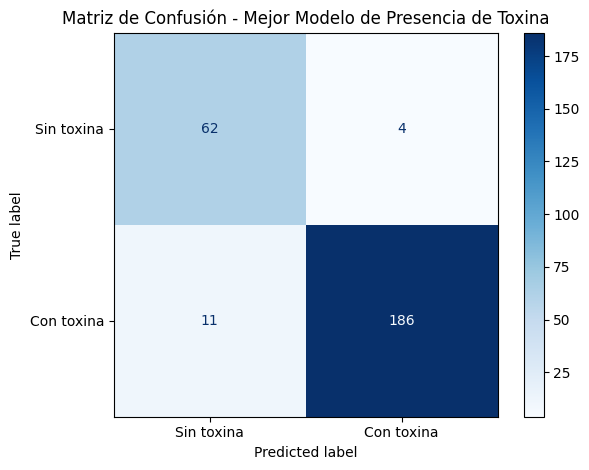

In [181]:
disp = ConfusionMatrixDisplay.from_estimator(
    mejor_modelo_presencia,
    X_val,
    y_val,
    display_labels=["Sin toxina", "Con toxina"],
    cmap="Blues",
    values_format="d"
    
)

plt.title("Matriz de Confusión - Mejor Modelo de Presencia de Toxina")
plt.grid(False)
plt.tight_layout()
plt.show()

Visualizacion curva ROC

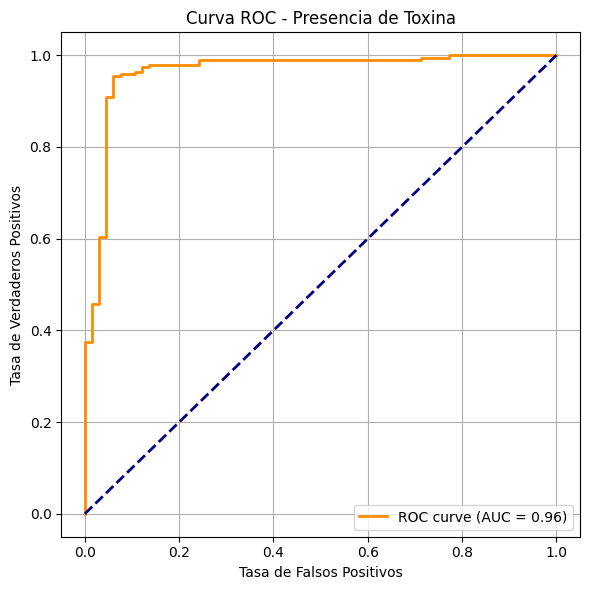

In [182]:
y_scores = mejor_modelo_presencia.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Presencia de Toxina")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Visualización comparativa de modelos

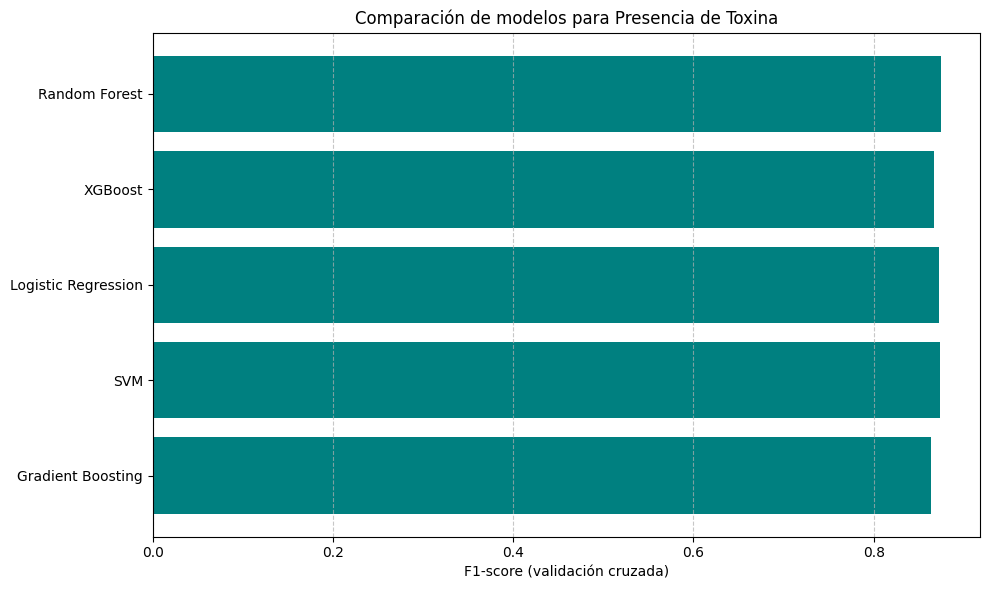

In [183]:
nombres_modelos = list(resultados.keys())
f1_scores = [info["mejor_score"] for info in resultados.values()]

plt.figure(figsize=(10, 6))
plt.barh(nombres_modelos, f1_scores, color="teal")
plt.xlabel("F1-score (validación cruzada)")
plt.title("Comparación de modelos para Presencia de Toxina")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Repetimos proceso para el dataframe de peligrosidad

In [184]:
X_peligrosidad = df_peligrosidad.drop(columns=["Fecha", "Peligrosidad"])
y_peligrosidad = df_peligrosidad["Peligrosidad"]

X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(
    X_peligrosidad, y_peligrosidad, test_size=0.2, stratify=y_peligrosidad, random_state=42
)

In [185]:
scorer_p = make_scorer(f1_score, average='macro') 

modelos_p = {
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=1),
        {
            "clf__n_estimators": randint(100, 500),
            "clf__max_depth": [None, 10, 20, 30],
            "clf__min_samples_split": randint(2, 11),
            "clf__min_samples_leaf": randint(1, 11),
            "clf__max_features": ["sqrt", "log2", 0.5, 0.7],
            "clf__bootstrap": [True, False]
        }
    ),

    "XGBoost": (
        XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False, n_jobs=1),
        {
            "clf__n_estimators": randint(100, 600),
            "clf__max_depth": randint(3, 10),
            "clf__learning_rate": loguniform(0.01, 0.3),
            "clf__subsample": uniform(0.7, 0.3),
            "clf__colsample_bytree": uniform(0.7, 0.3), 
            "clf__gamma": uniform(0, 0.5),
            "clf__reg_alpha": loguniform(1e-3, 1.0),
            "clf__reg_lambda": uniform(0.5, 1.5)
        }
    ),

    "Logistic Regression": (
        SkPipe([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=5000, solver='lbfgs'))
        ]),
        {
            "clf__C": loguniform(1e-3, 1e2),
            "clf__class_weight": [None, "balanced"]
        }
    ),

    "SVM": (
        SkPipe([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=42))
        ]),
        {
            "clf__C": loguniform(0.1, 100),
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma": ["scale", "auto", 0.001, 0.01, 0.1],
            "clf__class_weight": [None, "balanced"]
        }
    ),

    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": randint(100, 500),
            "clf__learning_rate": loguniform(0.01, 0.3),
            "clf__max_depth": randint(3, 10),
            "clf__min_samples_split": randint(2, 11),
            "clf__min_samples_leaf": randint(1, 11),
            "clf__subsample": uniform(0.7, 0.3),
            "clf__max_features": ["sqrt", "log2", 0.5, 0.7]
        }
    )
}


In [186]:
resultados_p = {}

for nombre, (modelo, grilla) in modelos_p.items():
    print(f"\n🔍 Entrenando {nombre}...")

    if isinstance(modelo, SkPipe):
        pipeline = ImbPipeline([("smote", SMOTE(random_state=42))] + modelo.steps)
        grilla_ajustada = grilla
    else:
        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf", modelo)
        ])
        grilla_ajustada = grilla

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grilla_ajustada,
        n_iter=50,
        scoring=scorer_p,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train_p, y_train_p)
    
    resultados_p[nombre] = {
        "mejor_modelo": search.best_estimator_,
        "mejor_score": search.best_score_,
        "mejores_params": search.best_params_
    }

    print(f"✅ Mejor F1-score: {search.best_score_:.3f}")
    print(f"📌 Hiperparámetros: {search.best_params_}")


mejor_nombre_peligrosidad = max(resultados_p, key=lambda k: resultados_p[k]["mejor_score"])
mejor_modelo_peligrosidad = resultados_p[mejor_nombre_peligrosidad]["mejor_modelo"]

print(f"\n🏆 Mejor modelo para Peligrosidad: {mejor_nombre_peligrosidad}")




🔍 Entrenando Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.941
📌 Hiperparámetros: {'clf__bootstrap': True, 'clf__max_depth': 30, 'clf__max_features': 0.7, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 4, 'clf__n_estimators': 406}

🔍 Entrenando XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Victor\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:44:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Mejor F1-score: 0.944
📌 Hiperparámetros: {'clf__colsample_bytree': np.float64(0.9425192044349383), 'clf__gamma': np.float64(0.15230688458668534), 'clf__learning_rate': np.float64(0.013940346079873234), 'clf__max_depth': 6, 'clf__n_estimators': 191, 'clf__reg_alpha': np.float64(0.020914981329035603), 'clf__reg_lambda': np.float64(0.6830573522671682), 'clf__subsample': np.float64(0.848553073033381)}

🔍 Entrenando Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.945
📌 Hiperparámetros: {'clf__C': np.float64(0.04661686413912769), 'clf__class_weight': 'balanced'}

🔍 Entrenando SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.947
📌 Hiperparámetros: {'clf__C': np.float64(1.3292918943162166), 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

🔍 Entrenando Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Mejor F1-score: 0.946
📌 Hiperparámetros:

In [187]:
y_val_pred_p = mejor_modelo_peligrosidad.predict(X_val_p)

print("📊 Evaluación del mejor modelo en conjunto de validación:")
print(confusion_matrix(y_val_p, y_val_pred_p))
print(classification_report(y_val_p, y_val_pred_p))

📊 Evaluación del mejor modelo en conjunto de validación:
[[182   8]
 [  8  65]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       190
           1       0.89      0.89      0.89        73

    accuracy                           0.94       263
   macro avg       0.92      0.92      0.92       263
weighted avg       0.94      0.94      0.94       263



In [188]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# Necesitamos SkPipe para reconstruir el pipeline de SVM
from sklearn.pipeline import Pipeline as SkPipe 

# =====================================================
# 🧠 1️⃣ STACKING - ETAPA PRESENCIA
# =====================================================

print("\n🚀 Entrenando STACKING para Presencia de Toxina...")

# 🔧 ¡CORREGIDO! Extraemos solo el clasificador ('clf') de cada pipeline guardado.
# Los modelos guardados en 'resultados' eran ImbPipelines [('smote', ...), ('clf', ...)]
estimadores_presencia = [
    ('best_rf', resultados['Random Forest']['mejor_modelo'].named_steps['clf']),
    ('best_xgb', resultados['XGBoost']['mejor_modelo'].named_steps['clf']),
    ('best_gb', resultados['Gradient Boosting']['mejor_modelo'].named_steps['clf'])
]

# Meta-modelo (ligero y generalista)
meta_model_presencia = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, random_state=42)
)

# Stacking con balanceo integrado
stack_presencia = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("stack", StackingClassifier(
        estimators=estimadores_presencia,
        final_estimator=meta_model_presencia,
        cv=5,
        n_jobs=-1,
        passthrough=True
    ))
])

# Entrenamiento
stack_presencia.fit(X_train, y_train) # <-- Correcto

# Evaluación
y_pred_stack_presencia = stack_presencia.predict(X_val)
print("\n📊 STACK PRESENCIA - Evaluación en Validación:")
print(confusion_matrix(y_val, y_pred_stack_presencia))
print(classification_report(y_val, y_pred_stack_presencia))


# =====================================================
# ⚡ 2️⃣ STACKING - ETAPA PELIGROSIDAD
# =====================================================

print("\n🚀 Entrenando STACKING para Peligrosidad...")

# 🔧 ¡CORREGIDO! Hacemos lo mismo, pero con cuidado especial en SVM.
# El pipeline de SVM era [('smote', ...), ('scaler', ...), ('clf', ...)]
# Necesitamos recrear un pipeline solo con [('scaler', ...), ('clf', ...)]

svm_pipeline_limpio = SkPipe(
    resultados_p['SVM']['mejor_modelo'].steps[1:] # <-- Extrae el paso 1 ('scaler') y 2 ('clf')
)

estimadores_peligrosidad = [
    ('best_rf_p', resultados_p['Random Forest']['mejor_modelo'].named_steps['clf']),
    ('best_xgb_p', resultados_p['XGBoost']['mejor_modelo'].named_steps['clf']),
    ('best_svm_p', svm_pipeline_limpio) # <-- Usamos el pipeline limpio
]

meta_model_peligrosidad = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, random_state=42)
)

stack_peligrosidad = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("stack", StackingClassifier(
        estimators=estimadores_peligrosidad,
        final_estimator=meta_model_peligrosidad,
        cv=5,
        n_jobs=-1,
        passthrough=True
    ))
])

stack_peligrosidad.fit(X_train_p, y_train_p)

y_pred_stack_peligrosidad = stack_peligrosidad.predict(X_val_p)
print("\n📊 STACK PELIGROSIDAD - Evaluación en Validación:")
print(confusion_matrix(y_val_p, y_pred_stack_peligrosidad))
print(classification_report(y_val_p, y_pred_stack_peligrosidad))



🚀 Entrenando STACKING para Presencia de Toxina...

📊 STACK PRESENCIA - Evaluación en Validación:
[[ 61   5]
 [  9 188]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90        66
           1       0.97      0.95      0.96       197

    accuracy                           0.95       263
   macro avg       0.92      0.94      0.93       263
weighted avg       0.95      0.95      0.95       263


🚀 Entrenando STACKING para Peligrosidad...

📊 STACK PELIGROSIDAD - Evaluación en Validación:
[[176  14]
 [  5  68]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       190
           1       0.83      0.93      0.88        73

    accuracy                           0.93       263
   macro avg       0.90      0.93      0.91       263
weighted avg       0.93      0.93      0.93       263



In [204]:
X_presencia_full = df_presencia.drop(columns=["Fecha", "PresenciaToxina"])
X_peligrosidad_full = df_peligrosidad.drop(columns=["Fecha", "Peligrosidad"])

In [205]:
# ==============================================
# 🧩 Predicciones finales con los STACKINGS
# ==============================================

# 1️⃣ Predicción de PRESENCIA (0 = no toxina, 1 = hay toxina)
df_modelo["presencia_pred"] = stack_presencia.predict(X_presencia_full)

# 2️⃣ Inicializar columna de PELIGROSIDAD
df_modelo["peligrosidad_pred"] = 0

# 3️⃣ Filtrar solo los registros donde hay toxina
indices_con_toxina = df_modelo[df_modelo["presencia_pred"] == 1].index

# 4️⃣ Aplicar modelo de PELIGROSIDAD solo en esos casos
df_modelo.loc[indices_con_toxina, "peligrosidad_pred"] = stack_peligrosidad.predict(
    X_peligrosidad_full.loc[indices_con_toxina]
)

# 5️⃣ (CORREGIDO) Crear columna final combinada: 0, 1, 2
# =========================================================

# Inicia la predicción final como 'presencia_pred' (mapea 0 -> 0 y 1 -> 1)
df_modelo["prediccion_final"] = df_modelo["presencia_pred"]

# Ahora, solo actualiza los casos que deben ser '2'
df_modelo.loc[
    (df_modelo["presencia_pred"] == 1) & (df_modelo["peligrosidad_pred"] == 1), 
    "prediccion_final"
] = 2

# ==============================================
# 🧾 Verificación rápida
# ==============================================
print("\nDistribución de predicciones finales:")
print(df_modelo["prediccion_final"].value_counts())

print("\nPrimeras filas:")
print(df_modelo[["presencia_pred", "peligrosidad_pred", "prediccion_final"]].head())



Distribución de predicciones finales:
prediccion_final
1    596
2    382
0    336
Name: count, dtype: int64

Primeras filas:
      presencia_pred  peligrosidad_pred  prediccion_final
95                 1                  0                 1
857                1                  0                 1
289                0                  0                 0
1279               1                  0                 1
204                0                  0                 0


Creación del clasificador jerárquico con los mejores modelos de cada etapa

### Resultados Finales

Evaluación del clasificador final con todo el set de datos

In [191]:
print("📈 Evaluación final del modelo jerárquico:")
print(confusion_matrix(df_modelo["Resultado_cat"], df_modelo["prediccion_final"]))
print(classification_report(df_modelo["Resultado_cat"], df_modelo["prediccion_final"]))

📈 Evaluación final del modelo jerárquico:
[[326   5   0]
 [ 10 583  27]
 [  0   8 355]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       331
           1       0.98      0.94      0.96       620
           2       0.93      0.98      0.95       363

    accuracy                           0.96      1314
   macro avg       0.96      0.97      0.96      1314
weighted avg       0.96      0.96      0.96      1314



Visualización de la matriz de confusión

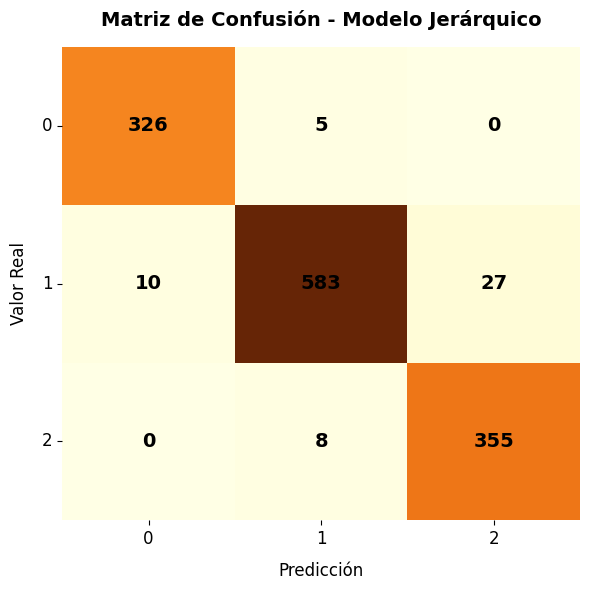

In [193]:
cm = confusion_matrix(df_modelo["Resultado_cat"], df_modelo["prediccion_final"])
labels = [0, 1, 2]

red_green = LinearSegmentedColormap.from_list("RedGreen", ["#ff0000", "#00ff00"])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size":14, "weight":"bold", "color":"black"},
            cmap="YlOrBr", cbar=False, square=False)

plt.title("Matriz de Confusión - Modelo Jerárquico", fontsize=14, weight="bold", pad=15)
plt.xlabel("Predicción", fontsize=12, labelpad=10)
plt.ylabel("Valor Real", fontsize=12, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()



Validacion del modelo con el dataset reservado

In [194]:
print("📈 Evaluación final del modelo jerárquico en df_val_final...")


try:
    original_features = X_train.columns 
except NameError:
    X_presencia = df_presencia.drop(columns=["Fecha", "PresenciaToxina"])
    y_presencia = df_presencia["PresenciaToxina"]
    X_train, _, _, _ = train_test_split(
        X_presencia, y_presencia, test_size=0.2, stratify=y_presencia, random_state=42
    )
    original_features = X_train.columns


X_final_presencia = df_val_final[original_features]
X_final_peligrosidad = df_val_final[original_features]


# 2. Predicción de PRESENCIA
df_val_final["presencia_pred"] = stack_presencia.predict(X_final_presencia)

# 3. Inicializar columna de PELIGROSIDAD
df_val_final["peligrosidad_pred"] = 0

# 4. Filtrar solo los registros donde hay toxina
indices_con_toxina_final = df_val_final[df_val_final["presencia_pred"] == 1].index

# 5. Aplicar modelo de PELIGROSIDAD solo en esos casos
df_val_final.loc[indices_con_toxina_final, "peligrosidad_pred"] = stack_peligrosidad.predict(
    X_final_peligrosidad.loc[indices_con_toxina_final]
)

# 6. Crear columna final combinada (0, 1, 2)
df_val_final["prediccion_final"] = df_val_final["presencia_pred"]
df_val_final.loc[
    (df_val_final["presencia_pred"] == 1) & (df_val_final["peligrosidad_pred"] == 1), 
    "prediccion_final"
] = 2

# 7. Evaluar contra las etiquetas reales de df_val_final
print("\n📊 Reporte de Clasificación (Datos Finales):")
print(confusion_matrix(df_val_final["Resultado_cat"], df_val_final["prediccion_final"]))
print(classification_report(
    df_val_final["Resultado_cat"], 
    df_val_final["prediccion_final"],
    labels=[0, 1, 2],
    zero_division=0 
))

📈 Evaluación final del modelo jerárquico en df_val_final...

📊 Reporte de Clasificación (Datos Finales):
[[35  2  0]
 [ 7 54  8]
 [ 1  2 37]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       0.93      0.78      0.85        69
           2       0.82      0.93      0.87        40

    accuracy                           0.86       146
   macro avg       0.86      0.88      0.87       146
weighted avg       0.87      0.86      0.86       146



Preparacion de los datos para visualizaciones

In [195]:
df_completo = pd.concat([df_modelo, df_val_final], ignore_index=True)

df_completo["Fecha"] = pd.to_datetime(df_completo["Fecha"])
df_completo["año"] = df_completo["Fecha"].dt.year
df_completo["mes"] = df_completo["Fecha"].dt.month
df_completo["día"] = df_completo["Fecha"].dt.day

In [196]:
def codificar_error_final(row):
    real = row['Resultado_cat']
    pred = row['prediccion_final']
    
    if real == pred:
        return real  # 0, 1 o 2 según acierto
    elif real == 0 and pred == 1:
        return 3 # FP Leve
    elif real == 0 and pred == 2:
        return 4 # FP Peligroso
    elif real == 1 and pred == 0:
        return 5 # FN Leve
    elif real == 1 and pred == 2:
        return 6 # FP Peligroso (sobre-alarma)
    elif real == 2 and pred == 0:
        return 7 # FN Peligroso (ERROR CRÍTICO)
    elif real == 2 and pred == 1:
        return 8 # FN Peligroso (ERROR CRÍTICO)

df_completo["codigo_error_final"] = df_completo.apply(codificar_error_final, axis=1)

In [197]:
leyenda_labels = {
    0: "(0) Acierto clase 0",
    1: "(1) Acierto clase 1",
    2: "(2) Acierto clase 2",
    3: "(3) Error: 0 → 1",
    4: "(4) Error: 0 → 2",
    5: "(5) Error: 1 → 0",
    6: "(6) Error: 1 → 2",
    7: "(7) Error: 2 → 0",
    8: "(8) Error: 2 → 1"
}

leyenda_colores = [
    "#2ca02c", "#1f77b4", "#ff7f0e",  # Aciertos (verde, azul, naranja)
    "#aec7e8", "#ffbb78", "#98df8a",  # Errores leves
    "#f7b6d2", "#c5b0d5", "#d62728"   # Errores graves (Rojo)
]

cmap = ListedColormap(leyenda_colores)
legend_patches = [Patch(color=leyenda_colores[i], label=leyenda_labels[i]) for i in range(9)]

Visualizacion de calendario con aciertos/errores de cada tipo

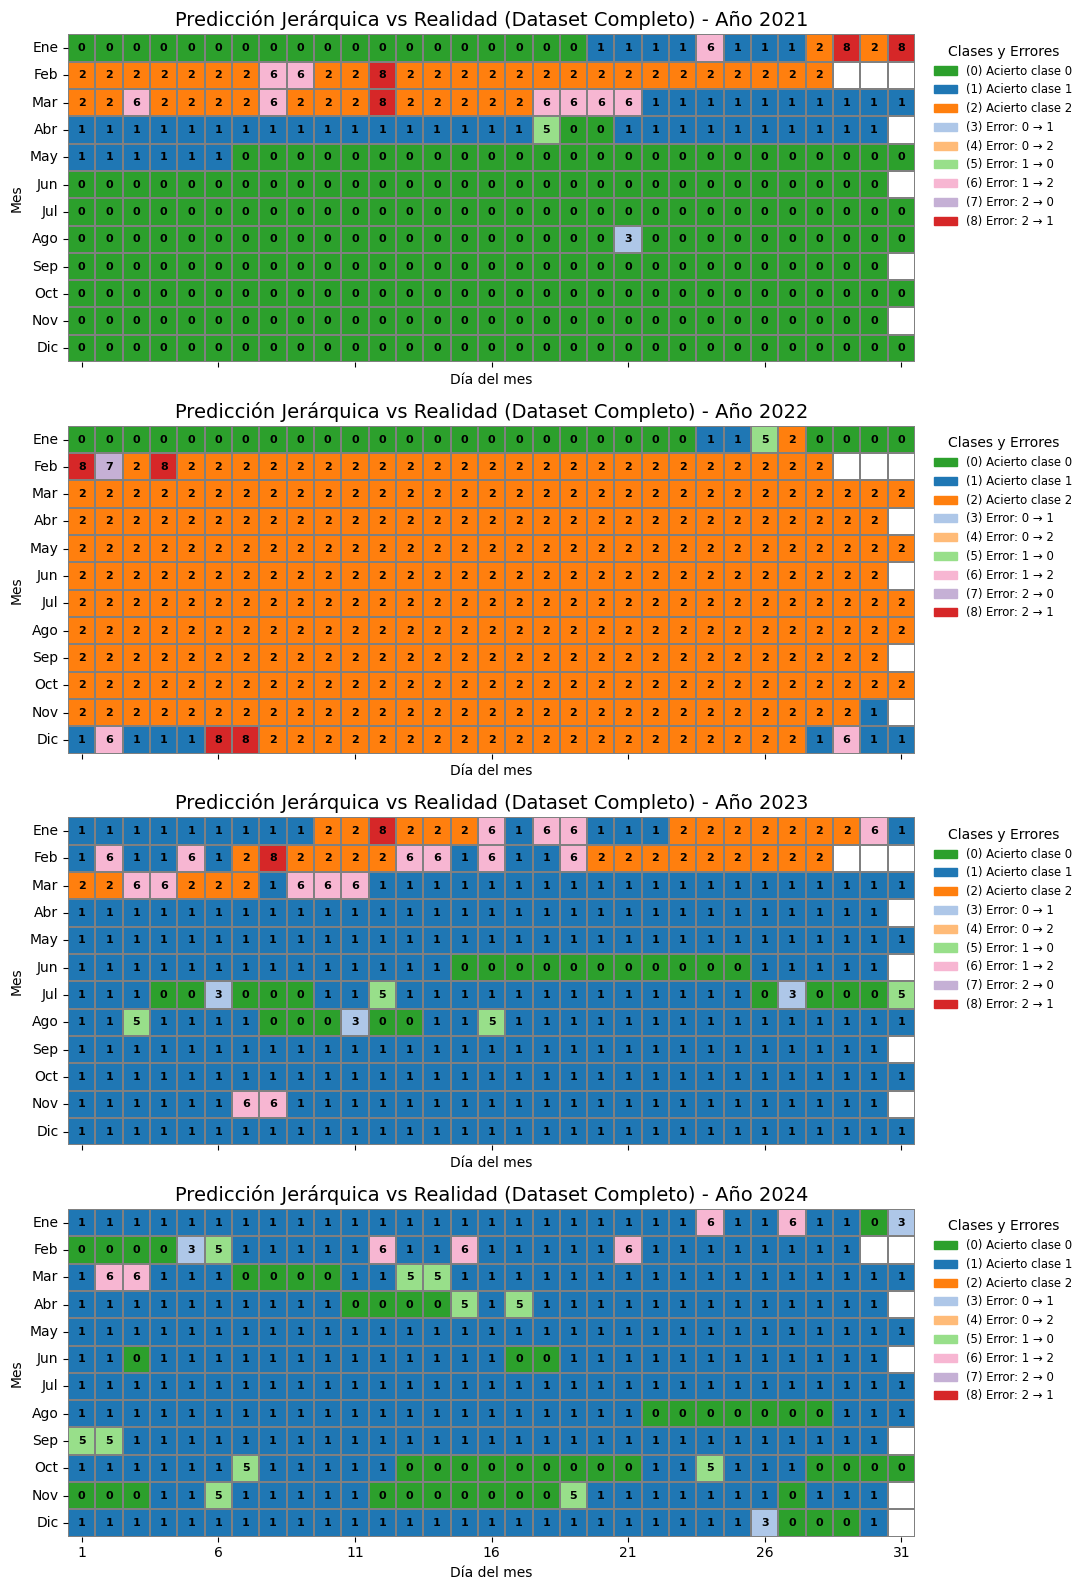

In [198]:
años = sorted(df_completo["año"].unique())
n_años = len(años)

fig, axs = plt.subplots(n_años, 1, figsize=(24, 4 * n_años), sharex=True)

if n_años == 1:
    axs = [axs]

for i, año in enumerate(años):
    df_año = df_completo[df_completo["año"] == año] 

    matriz = np.full((12, 31), np.nan)
    texto_matriz = np.full((12, 31), "", dtype=object)

    for _, row in df_año.iterrows():
        mes = row["mes"] - 1
        dia = row["día"] - 1
        cod = row["codigo_error_final"]

        if pd.notna(cod):
            matriz[mes, dia] = cod
            texto_matriz[mes, dia] = str(int(cod))

    ax = axs[i]
    sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        ax=ax,
        linewidths=0.2,
        linecolor='gray',
        vmin=0,
        vmax=8,
        square=True,
        annot=texto_matriz,
        fmt='',
        annot_kws={"size": 8, "color": "black", "weight": "bold"}
    )

    ax.set_title(f"Predicción Jerárquica vs Realidad (Dataset Completo) - Año {año}", fontsize=14)
    ax.set_ylabel("Mes")
    ax.set_yticks(np.arange(12) + 0.5)
    ax.set_yticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun",
                      "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=0)
    ax.set_xlabel("Día del mes")
    ax.set_xticks(np.arange(0, 31, 5) + 0.5)
    ax.set_xticklabels([str(d) for d in range(1, 32, 5)])

    ax.legend(handles=legend_patches, loc='upper left',
              bbox_to_anchor=(1.01, 1), fontsize='small', title="Clases y Errores", frameon=False)

plt.tight_layout()
plt.show()

Visualizacion por tipo de error

C:\Users\Victor\AppData\Local\Temp\ipykernel_11280\4128762381.py:11: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(x="Código", y="Frecuencia", data=df_ranking, hue="Código", legend = False, palette=leyenda_colores)


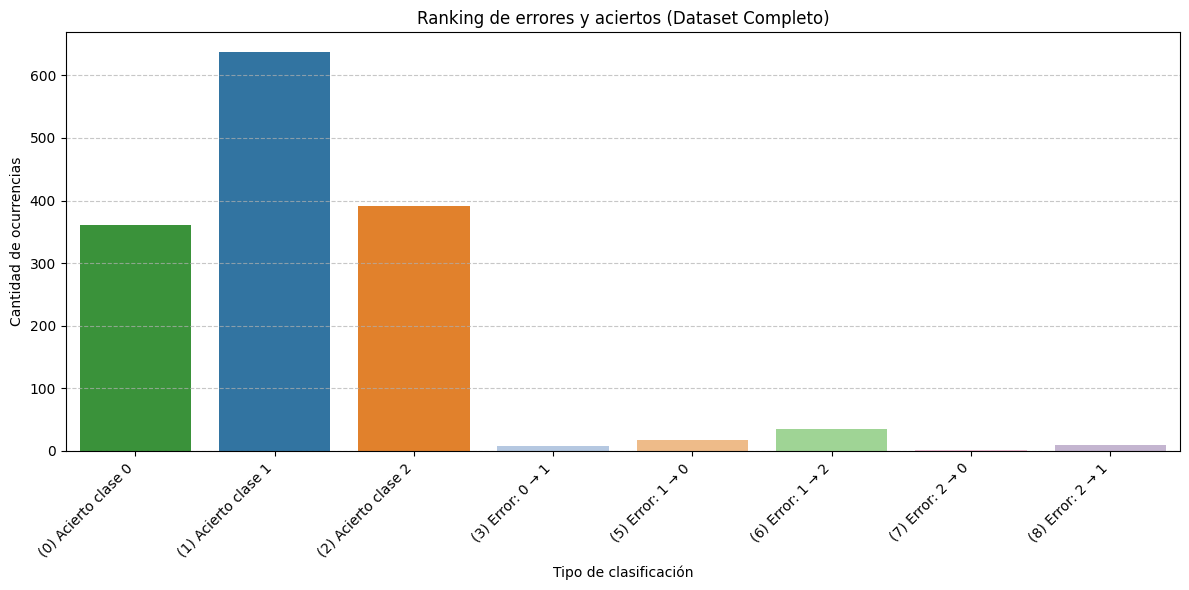

In [202]:
ranking = df_completo["codigo_error_final"].value_counts().sort_index()

df_ranking = pd.DataFrame({
    "Código": ranking.index,
    "Descripción": [leyenda_labels[c] for c in ranking.index],
    "Frecuencia": ranking.values
})

plt.figure(figsize=(12, 6))
# The barplot naturally creates ticks at positions 0, 1, 2, ...
sns.barplot(x="Código", y="Frecuencia", data=df_ranking, hue="Código", legend = False, palette=leyenda_colores)

# FIX: Use range(len(df_ranking)) to ensure the number of ticks matches the number of labels (descriptions)
plt.xticks(ticks=range(len(df_ranking)), labels=df_ranking["Descripción"], rotation=45, ha='right')

plt.title("Ranking de errores y aciertos (Dataset Completo)") 
plt.ylabel("Cantidad de ocurrencias")
plt.xlabel("Tipo de clasificación")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

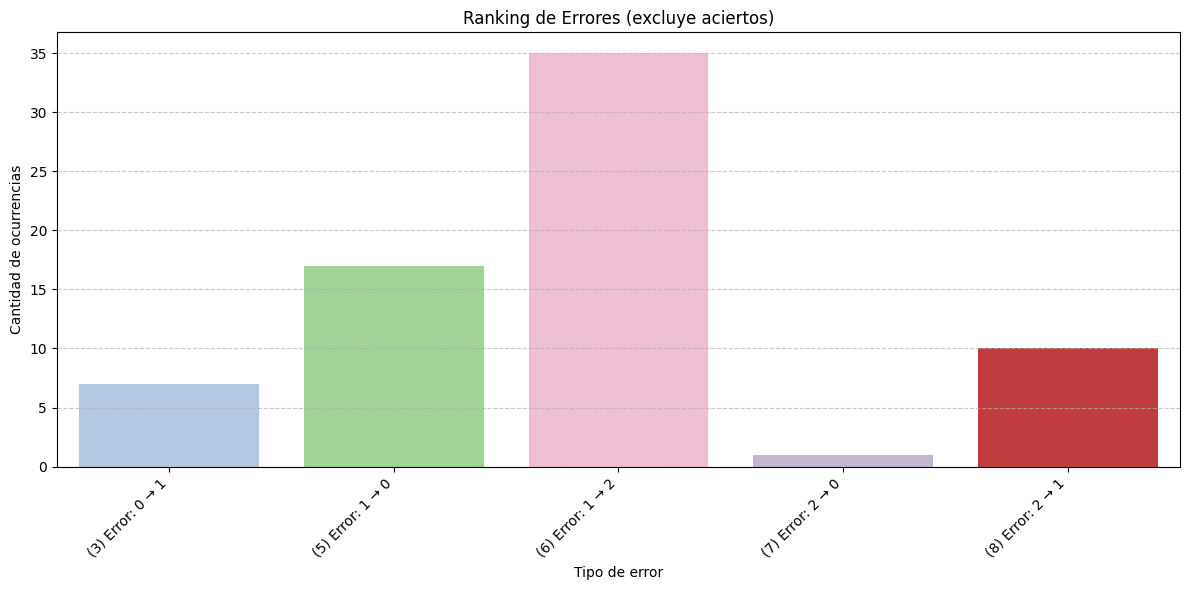

In [203]:
df_errores = df_ranking[~df_ranking["Código"].isin([0, 1, 2])].copy()

colores_errores_dict = {codigo: color for codigo, color in enumerate(leyenda_colores)}

plt.figure(figsize=(12, 6))

sns.barplot(
    x="Código", 
    y="Frecuencia", 
    data=df_errores, 
    palette=colores_errores_dict,
    hue="Código",
    legend=False
)

plt.xticks(ticks=range(len(df_errores)), labels=df_errores["Descripción"], rotation=45, ha='right')
plt.title("Ranking de Errores (excluye aciertos)")
plt.ylabel("Cantidad de ocurrencias")
plt.xlabel("Tipo de error")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()